# Experiment 02


The current approach for creating train, validation and test data sets is to split 
the data in long-format, i.e. one observation is an intensity value from one sample representing one peptide, into the desired splits. In this process missing values are not regarded.

- [x] mask entries in larger dataset in long-format
- [x] mask peptides based on their frequency in samples (probability of being observed)
- [x] create *long-format* training data set without masked values for each model
    - FNN based on embeddings of peptides and samples (long-format **without** missing values)
    - Denoising AE (wide-format **with** missing values)
    - VAE (wide-format **with** missing values)
- [ ] restrict to only a training data split of consective data: Increase number of samples.
    - focus on best reconstruction performance
    - mean comparison

### Collaborative Filtering model

- Cannot accomodate iid assumption of statistical test in current setup for embedding vectors.
  - if pretrained model should be applied to an new batch of replicates (with a certain condition) one would need to find a way to initialize the sample embeddings without fine-tuning the model

In [1]:
import logging
from pprint import pprint
import seaborn
import numpy.testing as npt  # fastcore.test functionality

from pathlib import Path


import vaep.io_images
from vaep.pandas import interpolate
from vaep.model import build_df_from_pred_batches

from src.nb_imports import *
from src import metadata
from src.logging import setup_logger

logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info("Experiment 02")

figures = {}  # collection of ax or figures

FOLDER_MQ_TXT_DATA = data\mq_out
vaep - INFO     Experiment 02


In [2]:
# None takes all
N_SAMPLES: int = 1000
n_features: int = 50
ADD_TENSORBOARD: bool = False
FN_PEPTIDE_INTENSITIES: Path = (
    config.FOLDER_DATA / 'df_intensities_N07285_M01000')  # 90%
epochs_max = 10
batch_size = 32
latent_dim = 2
most_common: bool = False
most_uncommon: bool = False
out_folder: str = 'poster'
# write to read only config ? namedtuple?

In [3]:
# Parameters
n_feat = 500
n_epochs = 10
out_folder = "runs/2D"


In [4]:
BATCH_SIZE, EPOCHS = batch_size, epochs_max
folder = Path(out_folder) / f'feat_{n_features:04d}_epochs_{epochs_max:03d}'
print(f"{folder = }")

if most_common and most_uncommon:
    raise ValueError(f"Cannot be both True: {most_common = } and {most_uncommon = }")

folder = Path('runs/2D/feat_0050_epochs_010')


## Raw data

In [5]:
FN_PEPTIDE_INTENSITIES = Path(FN_PEPTIDE_INTENSITIES)

In [6]:
analysis = AnalyzePeptides(fname=FN_PEPTIDE_INTENSITIES, nrows=None)
analysis.df.columns.name = 'peptide'
analysis.log_transform(np.log2)
analysis

AnalyzePeptides with attributes: M, N, df, index_col, is_log_transformed, is_wide_format, log_fct, stats

In [7]:
# some date are not possible in the indices
rename_indices_w_wrong_dates = {'20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_03': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_03',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_12': '20180330_QE10_nLC0_MR_QC_MNT_Hela_12',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_01': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_01',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_11': '20180330_QE10_nLC0_MR_QC_MNT_Hela_11',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_02': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_02'}
analysis.df.rename(index=rename_indices_w_wrong_dates, inplace=True)

### Select N consecutive samples

In [8]:
analysis.get_consecutive_dates(n_samples=N_SAMPLES)

Get 1000 samples.
Training data referenced unter: df_1000
Updated attribute: df


peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,31.517,32.278,30.832,31.541,32.803,33.676,31.927,31.906,27.631,33.747,...,31.452,28.512,29.634,31.134,30.690,30.142,29.881,31.508,29.884,29.468
20190805_QE1_nLC2_AB_MNT_HELA_01,31.104,31.747,28.999,28.458,30.588,28.800,32.415,31.270,30.077,32.357,...,29.504,29.435,28.424,29.489,29.702,29.877,28.777,30.471,27.793,29.185
20190805_QE1_nLC2_AB_MNT_HELA_02,31.248,31.923,28.643,28.257,31.068,28.864,32.340,31.672,31.636,32.466,...,29.728,29.741,28.667,29.647,29.555,29.709,28.592,30.776,27.955,29.272


In [9]:
assert not analysis.df._is_view

## Long format

- Data in long format: (peptide, sample_id, intensity)
- no missing values kept
- 

In [10]:
analysis.df_long.head()

intensity
Sample ID                           peptide                       
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAAAAAALQAK             29.591
                                    AAFDDAIAELDTLSEESYK     31.264
                                    AAHSEGNTTAGLDMR         28.098
                                    AAVATFLQSVQVPEFTPK      28.694
                                    AAVEEGIVLGGGCALLR       30.208

In [11]:
assert analysis.df_long.isna().sum().sum(
) == 0, "There are still missing values in the long format."

In [12]:
analysis.df_wide.head()

peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216


In [13]:
assert analysis.df_wide.isna().sum().sum(
) > 0, "There are no missing values left in the wide format"

### Sampling peptides by their frequency (important for later)

- higher count, higher probability to be sampled into training data
- missing peptides are sampled both into training as well as into validation dataset
- everything not in training data is validation data

In [14]:
# freq_per_peptide = analysis.df.unstack().to_frame('intensity').reset_index(1, drop=True)
freq_per_peptide = analysis.df_long['intensity']
freq_per_peptide = freq_per_peptide.notna().groupby(level=1).sum()
print(f"{n_features = }")


n_features = 50


### Selecting N
 - most common
 - most uncommon

In [15]:
freq_per_pepitde = freq_per_peptide.sort_values(ascending=False)

if most_common:
    freq_per_pepitde = freq_per_pepitde.iloc[:n_features]
elif most_uncommon:
    freq_per_pepitde = freq_per_pepitde.iloc[-n_features:]
else:
    freq_per_pepitde = freq_per_pepitde.sample(n_features)
    
assert len(freq_per_pepitde.index) == n_features

freq_per_pepitde

peptide
VNVPVIGGHAGK                 990
ELVYPPDYNPEGK                997
HIMGQNVADYMR                 999
SLEDQVEMLR                   982
SLHDALCVIR                   995
LMELHGEGSSSGK                992
LMIEMDGTENK                  999
ALPFWNEEIVPQIK               937
TLHPDLGTDK                   997
IVSRPEELREDDVGTGAGLLEIK      997
KHPDASVNFSEFSK               998
YADLTEDQLPSCESLK             998
TEFLSFMNTELAAFTK             994
NALESYAFNMK                  993
IVVVTAGVR                    981
VVVAENFDEIVNNENK             998
NMDPLNDNIATLLHQSSDK          996
LIAPVAEEEATVPNNK             997
LVNHFVEEFK                   980
GIHPTIISESFQK                999
AMVSEFLK                     984
AYHEQLSVAEITNACFEPANQMVK   1,000
TAVVVGTITDDVR                999
GLVEPVDVVDNADGTQTVNYVPSR     948
DSYVGDEAQSK                  999
TGTAEMSSILEER                999
NAGVEGSLIVEK                 992
YLTVAAVFR                    993
LSVLGAITSVQQR                959
NTDEMVELR                    996
TL

In [16]:
analysis.df = analysis.df[freq_per_pepitde.index]
# ToDo: clean-up other attributes needs to be integrated
del analysis._df_long  # , analysis._df_wide
analysis.df_long

intensity
Sample ID                           peptide                      
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 VNVPVIGGHAGK           27.985
                                    ELVYPPDYNPEGK          26.558
                                    HIMGQNVADYMR           28.806
                                    SLEDQVEMLR             28.105
                                    SLHDALCVIR             28.126
...                                                           ...
20190805_QE1_nLC2_AB_MNT_HELA_04    IVLLDSSLEYK            28.844
                                    AHSSMVGVNLPQK          28.602
                                    RFPGYDSESK             28.980
                                    NSVTPDMMEEMYK          28.778
                                    IYELAAGGTAVGTGLNTR     26.758

[49332 rows x 1 columns]

- biological stock differences in PCA plot. Show differences in models. Only see biological variance

## PCA plot of raw data

vaep - ERROR    Could not find LC instrument in 20190418_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190422_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190425_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190501_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190506_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190514_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190520_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190521_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190524_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190526_QX4_LiSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190527_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190530_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190603_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190606_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190607_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190611_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190615_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX8_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190618125902


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190619010035


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_centroid


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng_190621161214


vaep - ERROR    Could not find LC instrument in 20190624_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190629_QX4_JiYu_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190701_QX4_MePh_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190703_QX4_MaTa_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng_190707003046


vaep - ERROR    Could not find LC instrument in 20190717_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190718_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190719_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX4_StEb_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX8_ChSc_MA_HeLa_500ng_190722174431


vaep - ERROR    Could not find LC instrument in 20190725_QX2_MePh_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190726_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190731_QX8_ChSc_MA_HeLa_500ng


Created metadata DataFrame attribute `df_meta`.
Added proportion of not NA values based on `df` intensities.


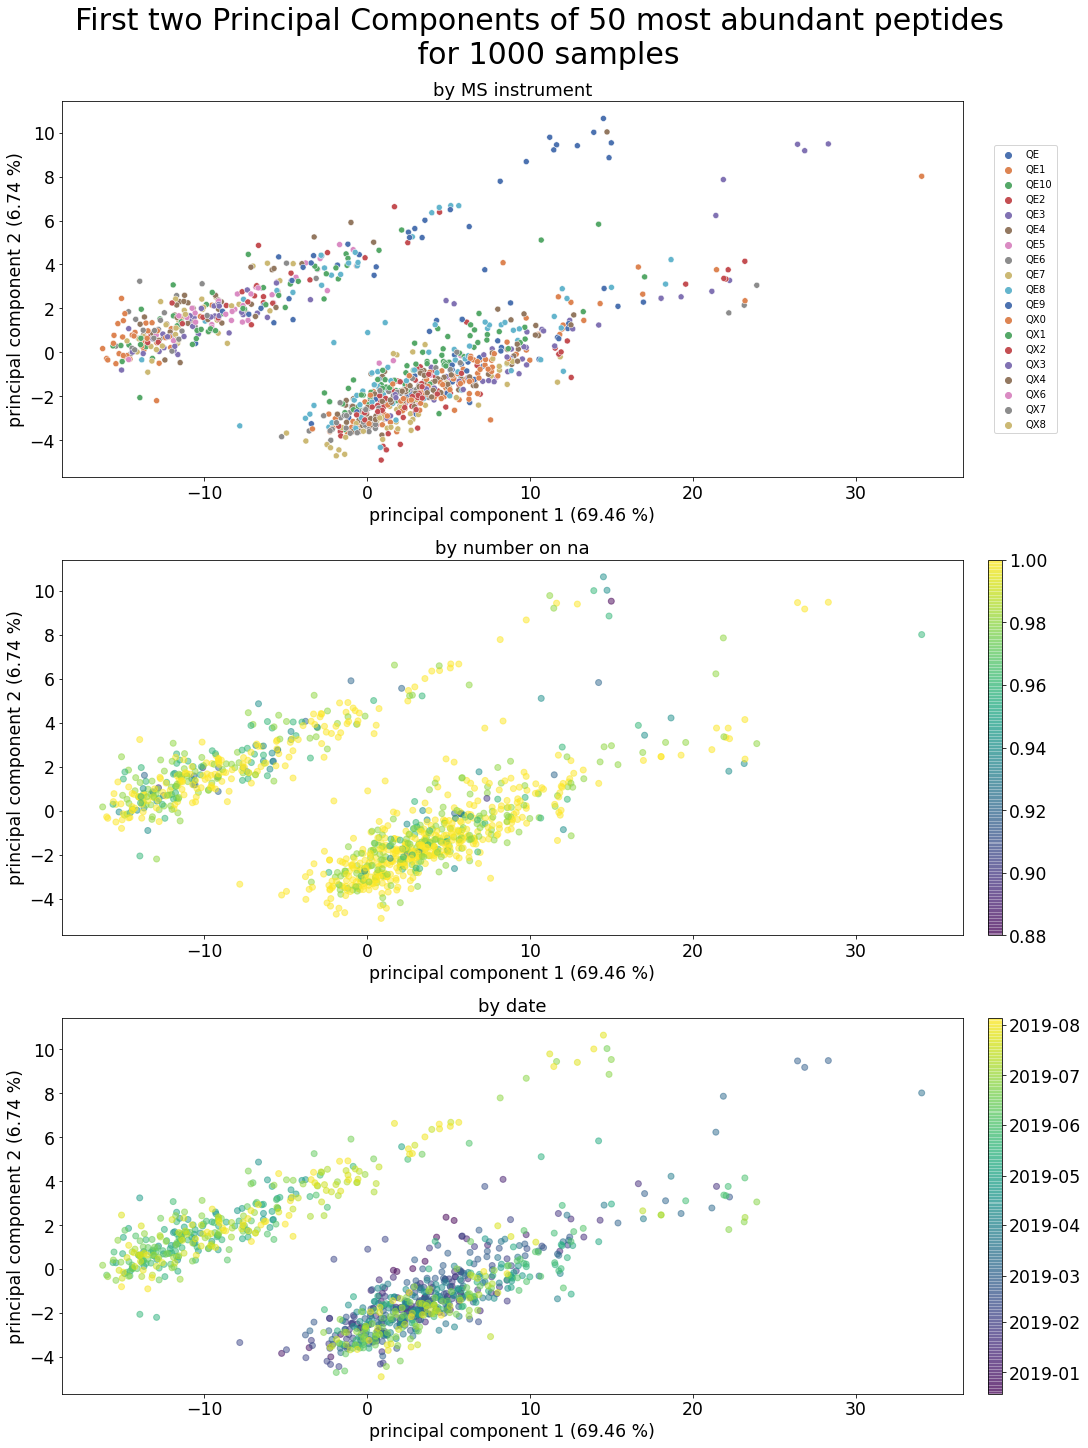

In [17]:
fig = analysis.plot_pca()

In [18]:
# ToDo add df_meta property
analysis.df_meta.describe()

,prop_not_na
count,"1,000.000"
mean,0.987
std,0.020
min,0.880
25%,0.980
50%,1.000
75%,1.000
max,1.000


In [19]:
vaep.io_images._savefig(fig, folder /
                        f'pca_plot_raw_data_{analysis.fname_stub}')

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\pca_plot_raw_data_N01000_M00050


## Train and Validation data

- use mulitindex for obtaining validation split

In [20]:
# analysis._df_long = analysis.df_long.reset_index(
# ).set_index(['Sample ID', 'peptide'])
analysis.df_long

intensity
Sample ID                           peptide                      
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 VNVPVIGGHAGK           27.985
                                    ELVYPPDYNPEGK          26.558
                                    HIMGQNVADYMR           28.806
                                    SLEDQVEMLR             28.105
                                    SLHDALCVIR             28.126
...                                                           ...
20190805_QE1_nLC2_AB_MNT_HELA_04    IVLLDSSLEYK            28.844
                                    AHSSMVGVNLPQK          28.602
                                    RFPGYDSESK             28.980
                                    NSVTPDMMEEMYK          28.778
                                    IYELAAGGTAVGTGLNTR     26.758

[49332 rows x 1 columns]

In [21]:
# df_long = analysis.df.unstack().to_frame('intensity').reset_index(1)
analysis.df_train = analysis.df_long.reset_index(0).groupby(
    by='Sample ID',
    level=0
).sample(frac=0.90,
         weights=freq_per_peptide,
         random_state=42)
analysis.df_train = analysis.df_train.reset_index().set_index([
    'Sample ID', 'peptide'])
analysis.df_train

,,intensity
Sample ID,peptide,
20190411_QE6_LC6_AS_QC_MNT_HeLa_02,AHSSMVGVNLPQK,29.949
20190730_QE1_nLC2_GP_MNT_HELA_02,AHSSMVGVNLPQK,28.333
20190624_QE6_LC4_AS_QC_MNT_HeLa_01,AHSSMVGVNLPQK,27.104
20190528_QX1_PhGe_MA_HeLa_DMSO_500ng_LC14_190528164924,AHSSMVGVNLPQK,32.006
20190208_QE2_NLC1_AB_QC_MNT_HELA_4,AHSSMVGVNLPQK,30.812
...,...,...
20190405_QE1_nLC2_GP_MNT_QC_hela_01,YLTVAAVFR,30.268
20190706_QX4_MiWi_MA_HeLa_500ng,YLTVAAVFR,32.232
20190527_QE4_LC12_AS_QC_MNT_HeLa_01,YLTVAAVFR,30.311


In [22]:
analysis.indices_valid = analysis.df_long.index.difference(
    analysis.df_train.index)
analysis.df_valid = analysis.df_long.loc[analysis.indices_valid]

In [23]:
assert len(analysis.df_long) == len(analysis.df_train) + len(analysis.df_valid)

Check that all samples are also in the validation data

In [24]:
assert analysis.df_train.index.levshape == (N_SAMPLES, n_features)

try:
    assert analysis.df_valid.index.levshape == (N_SAMPLES, n_features)
except AssertionError:
    print(f'Expected shape in validation: {(N_SAMPLES, n_features)}')
    print(f'Shape in validation: {analysis.df_valid.index.levshape}')

analysis.df_train = analysis.df_train.loc[analysis.df_valid.index.levels[0]]
analysis.df_train = analysis.df_train.reset_index().set_index(
    ['Sample ID', 'peptide'])  # update index categories (there is probably a better way)
N_SAMPLES = analysis.df_valid.index.levshape[0]
analysis.df_train.index.levshape, analysis.df_valid.index.levshape

Expected shape in validation: (1000, 50)
Shape in validation: (990, 50)


((990, 50), (990, 50))

## Setup DL

- [ ] move all above to separate data notebook

In [25]:
import vaep.models as models
from vaep.models.cmd import get_args
from vaep.models import ae

args = get_args(batch_size=BATCH_SIZE, epochs=EPOCHS,
                no_cuda=False)  # data transfer to GPU seems slow
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

# torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")
device

print(f"{args = }", f"{device = }", sep='\n')

args = Namespace(batch_size=32, cuda=True, epochs=10, log_interval=10, no_cuda=False, seed=43)
device = device(type='cuda')


Fastai default device for computation

In [26]:
import fastai.torch_core
print(f"{torch.cuda.is_available() = }")  # self-documenting python 3.8
fastai.torch_core.defaults

torch.cuda.is_available() = True


namespace(cpus=12,
          use_cuda=None,
          activation=torch.nn.modules.activation.ReLU,
          callbacks=[fastai.callback.core.TrainEvalCallback,
                     fastai.learner.Recorder,
                     fastai.callback.progress.ProgressCallback],
          lr=0.001)

### Comparison data

- first impute first and last row (using n=3 replicate)
- use pandas interpolate

In [27]:
analysis.median_train = analysis.df_train['intensity'].unstack().median()
analysis.median_train.name = 'train_median'
analysis.averag_train = analysis.df_train['intensity'].unstack().mean()
analysis.averag_train.name = 'train_average'

df_pred = analysis.df_valid.copy()

df_pred = df_pred.join(analysis.median_train, on='peptide')
df_pred = df_pred.join(analysis.averag_train, on='peptide')


_ = interpolate(wide_df=analysis.df_train['intensity'].unstack())
df_pred = df_pred.join(_)

df_pred

intensity  \
Sample ID                            peptide                               
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                29.899   
                                     DSYVGDEAQSK                  32.783   
                                     SLEDQVEMLR                   28.105   
                                     TLGILGLGR                    28.345   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK               29.217   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK             29.613   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK     31.539   
                                     IVSRPEELREDDVGTGAGLLEIK      30.671   
                                     LSVLGAITSVQQR                27.476   
                                     STGEAFVQFASQEIAEK            30.364   

                                                               train_median  \
Sample ID                            peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                   30.250   
                                     DSYVGDEAQSK                     33.542   
                                     SLEDQVEMLR                      28.950   
                                     TLGILGLGR                       28.815   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                  31.081   
...                                                                     ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                29.629   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK        31.468   
                                     IVSRPEELREDDVGTGAGLLEIK         29.922   
                                     LSVLGAITSVQQR                   27.545   
                                     STGEAFVQFASQEIAEK               30.274   

                                                               train_average  \
Sample ID                            peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                    30.245   
                                     DSYVGDEAQSK                      33.310   
                                     SLEDQVEMLR                       28.810   
                                     TLGILGLGR                        28.585   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                   30.827   
...                                                                      ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                 29.761   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK         31.570   
                                     IVSRPEELREDDVGTGAGLLEIK          30.016   
                                     LSVLGAITSVQQR                    27.684   
                                     STGEAFVQFASQEIAEK                30.238   

                                                               replicates  
Sample ID                            peptide                               
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                 30.008  
                                     DSYVGDEAQSK                   33.189  
                                     SLEDQVEMLR                    28.098  
                                     TLGILGLGR                     28.547  
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                30.196  
...                                                                   ...  
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK              29.744  
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK      31.623  
                                     IVSRPEELREDDVGTGAGLLEIK       30.115  
                                     LSVLGAITSVQQR                 27.425  
                                     STGEAFVQFASQEIAEK             30.494  

[4933 rows x 4 c

In [28]:
if any(df_pred.isna()):
    print("Consecutive NaNs are not imputed using replicates.")
    display(df_pred.loc[df_pred.isna().any(axis=1)])

Consecutive NaNs are not imputed using replicates.


,,intensity,train_median,train_average,replicates
Sample ID,peptide,,,,
20181230_QE6_nLC6_CSC_QC_HeLa_03,KHPDASVNFSEFSK,30.219,30.205,30.232,NaN
20190107_QE10_nLC0_KS_QC_MNT_HeLa_01,GVNLPGAAVDLPAVSEK,31.313,31.238,31.486,NaN
20190110_QE8_nLC14_JM_QC_MNT_HeLa_02,STGEAFVQFASQEIAEK,30.318,30.274,30.238,NaN
20190114_QE4_LC6_IAH_QC_MNT_HeLa_250ng_01,LVNHFVEEFK,30.359,28.285,29.359,NaN
20190121_QE5_nLC5_AH_QC_MNT_HeLa_250ng_01,SLEDQVEMLR,28.443,28.950,28.810,NaN
20190121_QE5_nLC5_AH_QC_MNT_HeLa_250ng_02,SLEDQVEMLR,28.568,28.950,28.810,NaN
20190204_QE6_nLC6_MPL_QC_MNT_HeLa_01,GVNLPGAAVDLPAVSEK,30.907,31.238,31.486,NaN
20190205_QE7_nLC7_MEM_QC_MNT_HeLa_03,HQPTAIIAK,33.074,32.208,32.028,NaN
20190205_QE7_nLC7_MEM_QC_MNT_HeLa_04,HQPTAIIAK,33.122,32.208,32.028,NaN


## Collaboritive filtering model

In [29]:
from fastai.collab import CollabDataLoaders, MSELossFlat, Learner
from fastai.collab import EmbeddingDotBias

analysis.collab = Analysis()
collab = analysis.collab
collab.columns = 'peptide,Sample ID,intensity'.split(',')

Create data view for collaborative filtering

- currently a bit hacky as the splitter does not support predefinded indices (create custum subclass providing splits to internal methods?)

- Use the [`CollabDataLoaders`](https://docs.fast.ai/collab.html#CollabDataLoaders)  similar to the [`TabularDataLoaders`](https://docs.fast.ai/tabular.data.html#TabularDataLoaders).
- Use the [`IndexSplitter`](https://docs.fast.ai/data.transforms.html#IndexSplitter) and provide splits to whatever is used in `CollabDataLoaders`


In [30]:
collab.df_train = analysis.df_train.reset_index()
collab.df_valid = analysis.df_valid.reset_index()
collab.df_train.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ALPFWNEEIVPQIK,29.497
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AMVSEFLK,28.042
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AYHEQLSVAEITNACFEPANQMVK,30.245
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ELAPYDENWFYTR,27.436
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ELVYPPDYNPEGK,26.558


In [31]:
collab.df_valid.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AHSSMVGVNLPQK,29.899
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,DSYVGDEAQSK,32.783
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,SLEDQVEMLR,28.105
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,TLGILGLGR,28.345
4,20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,ALPFWNEEIVPQIK,29.217


In [32]:
assert (collab.df_train.intensity.isna().sum(),
        collab.df_valid.intensity.isna().sum()) == (0, 0), "Remove missing values."

Hacky part uses training data `Datasets` from dataloaders to recreate a custom `DataLoaders` instance

In [33]:
collab.dl_train = CollabDataLoaders.from_df(
    collab.df_train, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size, device=device)
collab.dl_valid = CollabDataLoaders.from_df(
    collab.df_valid, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size,
    shuffle=False, device=device)
collab.dl_train.show_batch()

,Sample ID,peptide,intensity
0,20190412_QE6_LC6_AS_QC_MNT_HeLa_01,LNNLVLFDK,30.486
1,20190718_QE9_nLC9_NHS_MNT_HELA_50cm_01,YDDMATCMK,26.540
2,20190621_QX2_SeVW_MA_HeLa_500ng_LC05,HELLQPFNVLYEK,30.399
3,20190422_QX8_JuSc_MA_HeLa_500ng_1,KHPDASVNFSEFSK,30.495
4,20190205_QE7_nLC7_MEM_QC_MNT_HeLa_03,SLHDALCVIR,30.043
5,20190702_QE3_nLC5_GF_QC_MNT_Hela_01,NTDEMVELR,27.828
6,20190417_QE4_LC12_JE-IAH_QC_MNT_HeLa_03,VSFELFADK,30.373
7,20190211_QE4_nLC12_SIS_QC_MNT_Hela_2,RFPGYDSESK,28.667
8,20190618_QX3_LiSc_MA_Hela_500ng_LC15,NTDEMVELR,30.943
9,20190528_QX6_AsJa_MA_HeLa_Br14_500ng_LC09,HIMGQNVADYMR,30.559


In [34]:
from fastai.data.core import DataLoaders
collab.dls = DataLoaders(collab.dl_train.train, collab.dl_valid.train)
if args.cuda:
    collab.dls.cuda()

In [35]:
collab.dl_valid.show_batch()

,Sample ID,peptide,intensity
0,20190606_QE4_LC12_JE_QC_MNT_HeLa_03,RGEAHLAVNDFELAR,28.706
1,20190510_QE2_NLC1_GP_MNT_HELA_02,TLGILGLGR,28.640
2,20190726_QE7_nLC7_MEM_QC_MNT_HeLa_03,AYHEQLSVAEITNACFEPANQMVK,31.619
3,20190621_QX4_JoMu_MA_HeLa_500ng_190621161214,TGTAEMSSILEER,31.227
4,20190225_QE10_PhGe_Evosep_88min_HeLa_6,AHSSMVGVNLPQK,29.437
5,20190626_QE7_nLC7_DS_QC_MNT_HeLa_02,VNVPVIGGHAGK,26.298
6,20190626_QX6_ChDe_MA_HeLa_500ng_LC09,TEFLSFMNTELAAFTK,32.885
7,20190803_QE9_nLC13_RG_SA_HeLa_50cm_350ng,YDDMATCMK,28.988
8,20190715_QE2_NLC1_ANHO_MNT_HELA_02,LMIEMDGTENK,32.776
9,20190712_QE10_nLC0_LiNi_QC_45cm_HeLa_MUC_01,AHSSMVGVNLPQK,31.777


In [36]:
len(collab.dls.classes['Sample ID']), len(collab.dls.classes['peptide'])

(991, 51)

In [37]:
len(collab.dls.train), len(collab.dls.valid)  # mini-batches

(1372, 155)

Alternatively to the hacky version, one could use a factory method, but there the sampling/Splitting methods would need to be implemented (not using [`RandomSplitter`](https://docs.fast.ai/data.transforms.html#RandomSplitter) somehow)

 - [`TabDataLoader`](https://docs.fast.ai/tabular.core.html#TabDataLoader)
 - uses [`TabularPandas`](https://docs.fast.ai/tabular.core.html#TabularPandas)
 
 > Current problem: No custom splitter can be provided

### Model

In [38]:
collab.model_args = {}
collab.model_args['n_samples'] = len(collab.dls.classes['Sample ID'])
collab.model_args['n_peptides'] = len(collab.dls.classes['peptide'])
collab.model_args['dim_latent_factors'] = latent_dim
collab.model_args['y_range'] = (
    int(analysis.df_train['intensity'].min()), int(analysis.df_train['intensity'].max())+1)

print("Args:")
pprint(collab.model_args)


# from vaep.models.collab import DotProductBias
# model = DotProductBias(**collab.model_args)
model = EmbeddingDotBias.from_classes(
    n_factors=collab.model_args['dim_latent_factors'], classes=collab.dls.classes, y_range=collab.model_args['y_range'])
learn = Learner(dls=collab.dls, model=model, loss_func=MSELossFlat())
if args.cuda:
    learn.cuda()
learn.summary()

Args:
{'dim_latent_factors': 2,
 'n_peptides': 51,
 'n_samples': 991,
 'y_range': (20, 36)}


EmbeddingDotBias (Input shape: 32 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 2              
Embedding                                 1982       True      
Embedding                                 102        True      
____________________________________________________________________________
                     32 x 1              
Embedding                                 991        True      
Embedding                                 51         True      
____________________________________________________________________________

Total params: 3,126
Total trainable params: 3,126
Total non-trainable params: 0

Optimizer used: <function Adam at 0x000001CBC0506040>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

### Training

In [39]:
learn.fit_one_cycle(epochs_max, 5e-3)

epoch,train_loss,valid_loss,time
0,1.746584,1.643620,00:07
1,0.664948,0.672359,00:07
2,0.571682,0.615115,00:08
3,0.514574,0.563398,00:08
4,0.547034,0.532022,00:09
5,0.461233,0.518302,00:09
6,0.432974,0.509214,00:09
7,0.416380,0.506805,00:09
8,0.377849,0.502489,00:09
9,0.439591,0.502159,00:09


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_training


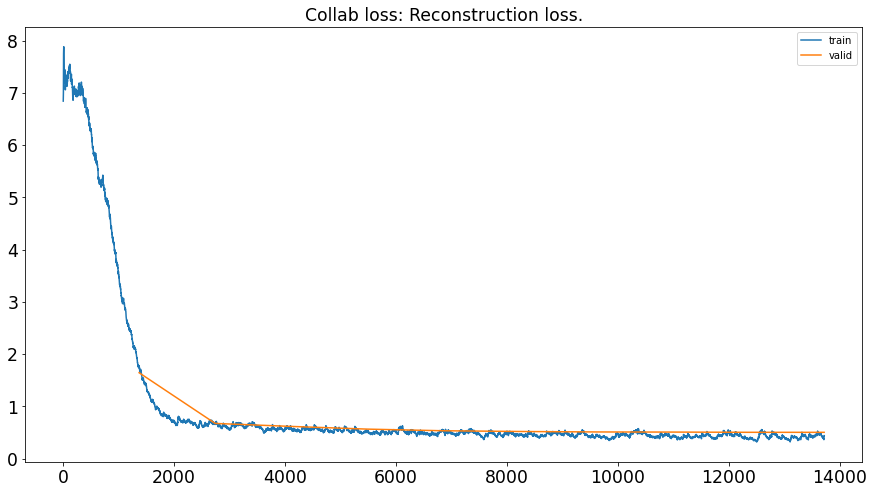

In [40]:
from vaep.models import plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Collab loss: Reconstruction loss.')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='collab_training',
                        folder=folder)

### Evaluation

In [41]:
collab.dls.valid_ds.items

,Sample ID,peptide,intensity
"3,161",634,34,28.706
"2,512",502,43,28.640
"4,616",928,4,31.619
"3,556",717,42,31.227
"1,136",217,1,29.437
...,...,...,...
9,3,10,31.245
484,97,3,27.915
"2,518",503,37,27.225
"1,407",276,44,32.527


In [42]:
df_pred = df_pred.reset_index()
pred, target = learn.get_preds()
df_pred['intensity_pred_collab'] = pd.Series(
    pred.flatten().numpy(), index=collab.dls.valid.items.index)

npt.assert_almost_equal(
    actual=collab.dls.valid.items.intensity.to_numpy(),
    desired=target.numpy().flatten()
)


df_pred = analyzers.cast_object_to_category(df_pred)
df_pred.set_index(['Sample ID', 'peptide'], inplace=True)
df_pred

intensity  \
Sample ID                            peptide                               
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                29.899   
                                     DSYVGDEAQSK                  32.783   
                                     SLEDQVEMLR                   28.105   
                                     TLGILGLGR                    28.345   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK               29.217   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK             29.613   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK     31.539   
                                     IVSRPEELREDDVGTGAGLLEIK      30.671   
                                     LSVLGAITSVQQR                27.476   
                                     STGEAFVQFASQEIAEK            30.364   

                                                               train_median  \
Sample ID                            peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                   30.250   
                                     DSYVGDEAQSK                     33.542   
                                     SLEDQVEMLR                      28.950   
                                     TLGILGLGR                       28.815   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                  31.081   
...                                                                     ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                29.629   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK        31.468   
                                     IVSRPEELREDDVGTGAGLLEIK         29.922   
                                     LSVLGAITSVQQR                   27.545   
                                     STGEAFVQFASQEIAEK               30.274   

                                                               train_average  \
Sample ID                            peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                    30.245   
                                     DSYVGDEAQSK                      33.310   
                                     SLEDQVEMLR                       28.810   
                                     TLGILGLGR                        28.585   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                   30.827   
...                                                                      ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                 29.761   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK         31.570   
                                     IVSRPEELREDDVGTGAGLLEIK          30.016   
                                     LSVLGAITSVQQR                    27.684   
                                     STGEAFVQFASQEIAEK                30.238   

                                                               replicates  \
Sample ID                            peptide                                
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                 30.008   
                                     DSYVGDEAQSK                   33.189   
                                     SLEDQVEMLR                    28.098   
                                     TLGILGLGR                     28.547   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                30.196   
...                                                                   ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK              29.744   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK      31.623   
                                     IVSRPEELREDDVGTGAGLLEIK       30.115   
                                     LSVLGAITSVQQR                 27.425   
                                     STGEAFVQFASQEIAEK             30.494   

   

In [43]:
assert (abs(target.reshape(-1) - pred.reshape(-1))).sum() / len(target) - \
    (df_pred.intensity - df_pred.intensity_pred_collab).abs().sum() / \
    len(df_pred) < 0.00001

### Plot biases and embedding weigths

- visualize relative order of samples and peptides

In [44]:
from collections import namedtuple
def get_bias(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.bias(indices.values, is_item=is_item) # user=sample
    return pd.Series(ret, index=indices)

# def get_weigths

CollabIDs = namedtuple("CollabIDs", "sample peptide")

collab.biases = CollabIDs(
    sample=get_bias(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_bias(learn, indices=analysis.df_train.index.levels[1] )
)
collab.biases.sample.head()

Sample ID
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02     0.036
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01    0.062
20181221_QE8_nLC0_NHS_MNT_HeLa_01       0.184
20181222_QE9_nLC9_QC_50CM_HeLa1         0.110
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01   0.162
dtype: float32

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_samples


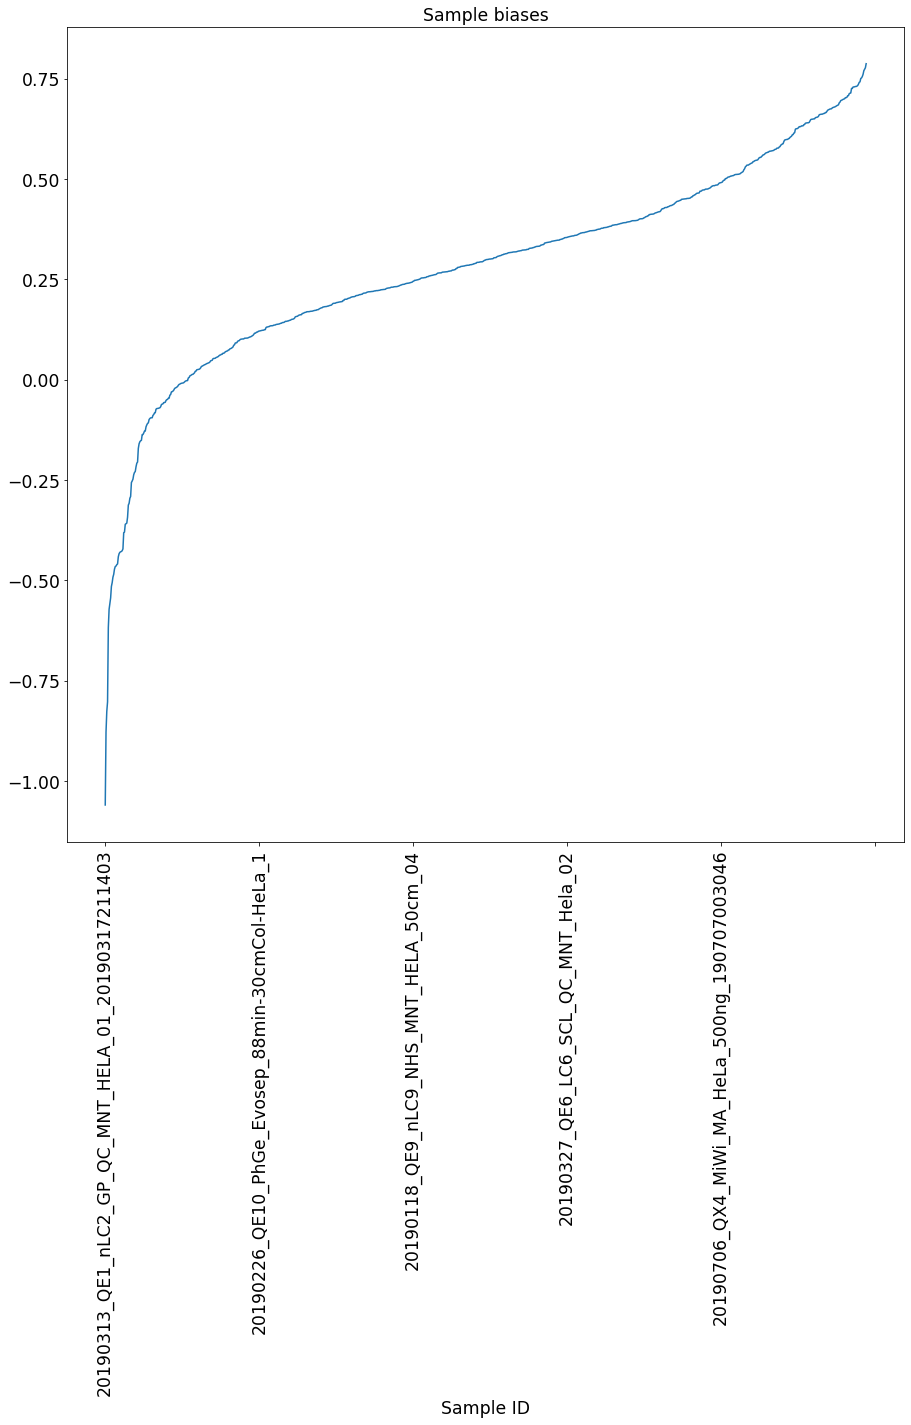

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = collab.biases.sample.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_samples',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_peptides


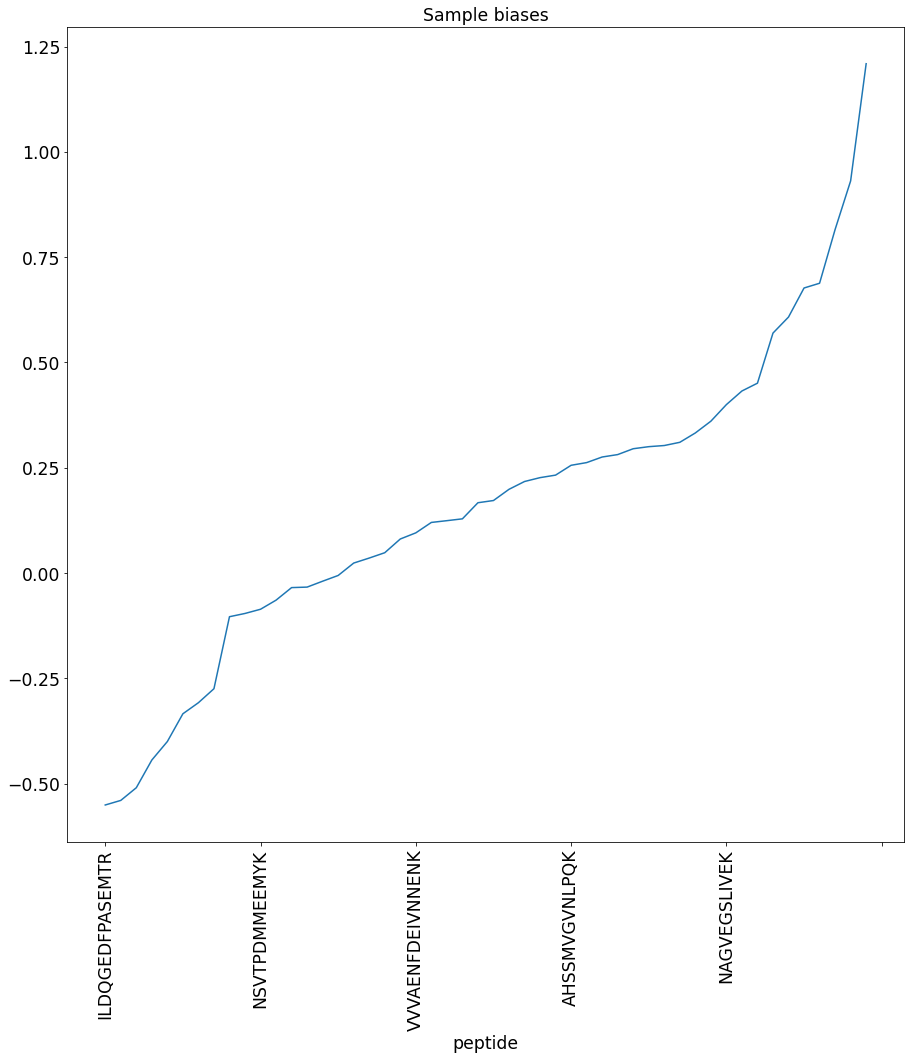

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = collab.biases.peptide.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_peptides',
                        folder=folder)

In [47]:
def get_weight(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.weight(indices.values, is_item=is_item) # user=sample
    return pd.DataFrame(ret, index=indices, columns=[f'latent dimension {i+1}' for i in range(ret.shape[-1])])

collab.embeddings = CollabIDs(
    sample=get_weight(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_weight(learn, indices=analysis.df_train.index.levels[1] )
)
collab.embeddings.sample.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.231,-0.116
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.230,-0.149
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.077,0.057
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.041,-0.205
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.059,-0.077


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_date


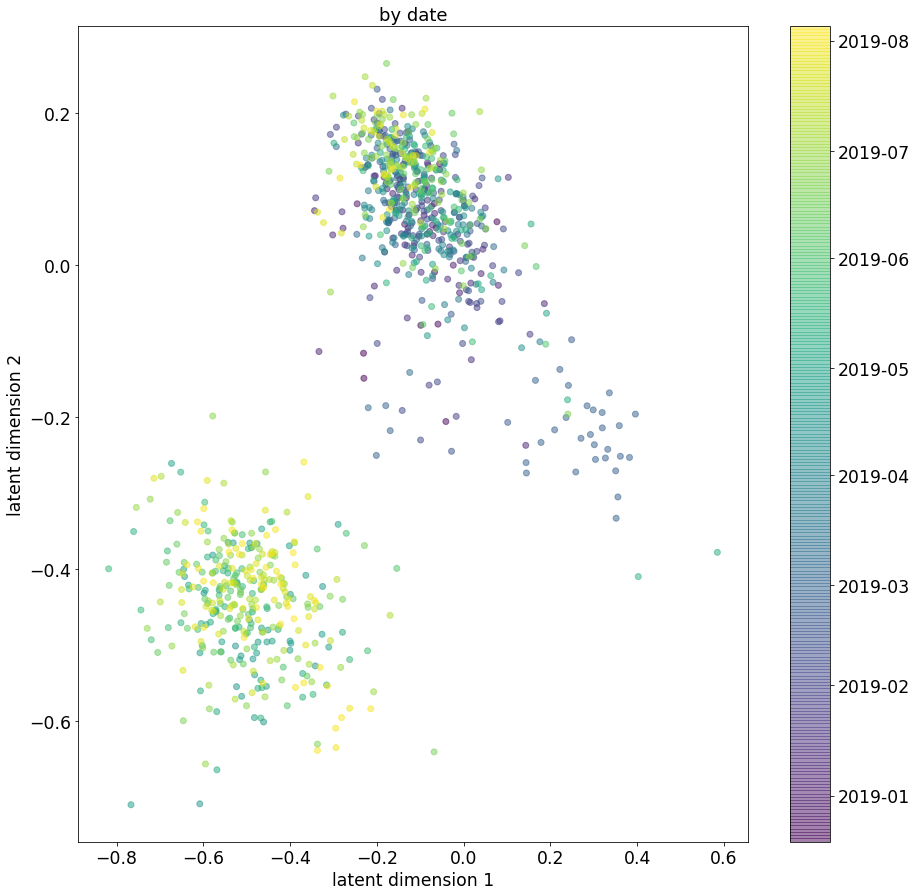

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=collab.embeddings.sample, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[collab.embeddings.sample.index])
vaep.io_images._savefig(fig, name='collab_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_ms_instrument


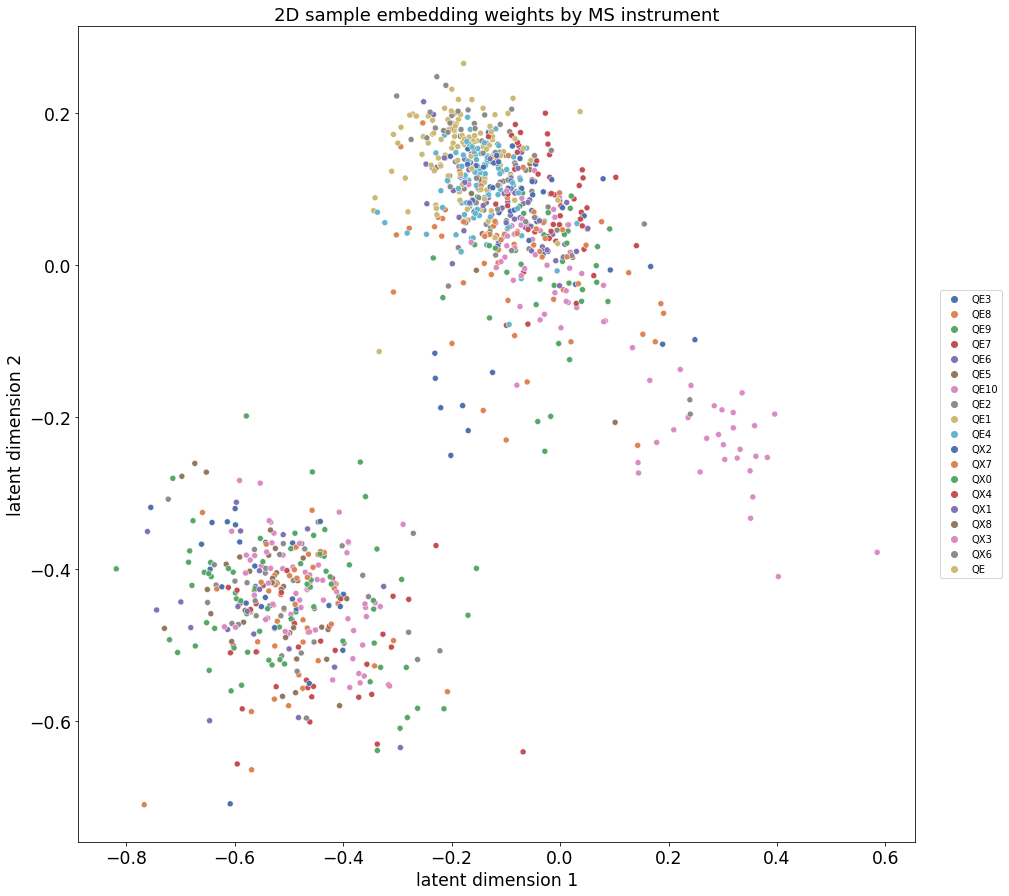

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
meta_col = 'ms_instrument'

df_ = collab.embeddings.sample
analyzers.seaborn_scatter(df=df_,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_.index],
                          title='2D sample embedding weights by MS instrument')

vaep.io_images._savefig(fig, name='collab_latent_by_ms_instrument',
                        folder=folder)

## Denoising Autoencoder (DAE)

### Custom Transforms

- [x] Shift standard normalized data around
    - Error metrics won't be directly comparable afterwards

In [50]:
from fastai.tabular.all import *
from vaep.models import ae

from fastai.tabular.core import TabularPandas

# from fastai.callback.core import Callback

from fastai.data.core import DataLoaders

from fastai.learner import Learner
from fastai.losses import MSELossFlat


# https://docs.fast.ai/tabular.core.html#FillStrategy
# from fastai.tabular.core import FillMissing
# from fastai.tabular.core import TabularPandas

### DataLoaders

In [51]:
# revert format
# undo using `stack`
analysis.df_train = analysis.df_train['intensity'].unstack()
analysis.df_valid = analysis.df_valid['intensity'].unstack()
analysis.df_valid.head()

peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK,...,TEFLSFMNTELAAFTK,TGTAEMSSILEER,TLGILGLGR,TLHPDLGTDK,VNVPVIGGHAGK,VSFELFADK,VVVAENFDEIVNNENK,YADLTEDQLPSCESLK,YDDMATCMK,YLTVAAVFR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.899,NaN,NaN,NaN,32.783,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28.345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,29.217,NaN,NaN,NaN,NaN,26.450,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,30.178,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.452
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,32.954,NaN,NaN,NaN,28.494,NaN,...,NaN,29.912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mean and std. dev. from training data

In [52]:
# norm = Normalize.from_stats(analysis.df_train.mean(), analysis.df_valid.std()) # copy interface?
NORMALIZER = Normalize  # dae.NormalizeShiftedMean

#### Training data

procs passed to TabluarPandas are handled internally 
  1. not necessarily in order
  2. with setup call (using current training data)

In [53]:
procs = [NORMALIZER, FillMissing(add_col=True)]
cont_names = list(analysis.df_train.columns)

to = TabularPandas(analysis.df_train, procs=procs, cont_names=cont_names)
print("Tabular object:", type(to))

to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK,...,TEFLSFMNTELAAFTK_na,TGTAEMSSILEER_na,TLGILGLGR_na,TLHPDLGTDK_na,VNVPVIGGHAGK_na,VSFELFADK_na,VVVAENFDEIVNNENK_na,YADLTEDQLPSCESLK_na,YDDMATCMK_na,YLTVAAVFR_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.004,-1.021,-0.843,-1.000,0.197,-1.528,-1.082,-1.328,0.895,-0.768,...,False,False,True,False,False,False,False,False,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.186,0.160,-1.063,-0.965,-0.430,-1.560,-0.079,-1.195,0.715,-0.760,...,False,False,False,False,False,False,False,False,False,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.248,0.021,-1.083,-0.733,0.156,-0.526,0.880,-0.647,-0.080,-0.169,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,0.105,-1.198,-0.791,-0.070,-0.031,-0.972,0.430,-1.200,1.129,0.024,...,False,False,False,False,False,False,False,False,False,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.142,0.033,0.552,-0.528,0.197,0.527,-0.571,-1.153,-0.003,-0.212,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.222,0.720,0.263,1.474,0.216,0.683,0.695,0.519,-0.003,0.902,...,False,False,False,False,True,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,0.583,-0.071,-0.047,0.097,0.259,-0.140,-0.744,-0.155,-0.364,-0.626,...,False,True,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.391,0.160,-0.073,0.049,0.463,0.212,-0.262,-0.048,-0.414,-0.672,...,True,False,False,False,False,False,False,False,False,False


Better manuelly apply `Transforms` on `Tabluar` type

In [54]:
cont_names = list(analysis.df_train.columns)
to = TabularPandas(analysis.df_train, cont_names=cont_names, do_setup=False)

tf_norm = NORMALIZER()
_ = tf_norm.setups(to)  # returns to
tf_fillna = FillMissing(add_col=True)
_ = tf_fillna.setup(to)

print("Tabular object:", type(to))
# _ = (procs[0]).encodes(to)
to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK,...,TEFLSFMNTELAAFTK_na,TGTAEMSSILEER_na,TLGILGLGR_na,TLHPDLGTDK_na,VNVPVIGGHAGK_na,VSFELFADK_na,VVVAENFDEIVNNENK_na,YADLTEDQLPSCESLK_na,YDDMATCMK_na,YLTVAAVFR_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.004,-0.912,-0.775,-0.956,0.208,-1.398,-1.033,-1.268,0.826,-0.747,...,False,False,True,False,False,False,False,False,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.176,0.175,-0.983,-0.923,-0.387,-1.427,-0.083,-1.141,0.660,-0.740,...,False,False,False,False,False,False,False,False,False,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.235,0.046,-1.001,-0.703,0.170,-0.468,0.824,-0.623,-0.074,-0.179,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,0.100,-1.074,-0.726,-0.074,-0.008,-0.882,0.398,-1.147,1.043,0.005,...,False,False,False,False,False,False,False,False,False,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.134,0.058,0.539,-0.508,0.208,0.508,-0.549,-1.102,-0.004,-0.220,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.210,0.690,0.267,1.391,0.226,0.653,0.650,0.483,-0.004,0.839,...,False,False,False,False,True,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,0.553,-0.038,-0.025,0.085,0.268,-0.110,-0.713,-0.156,-0.337,-0.613,...,False,True,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.371,0.175,-0.049,0.039,0.461,0.217,-0.257,-0.054,-0.383,-0.656,...,True,False,False,False,False,False,False,False,False,False


Check mean and standard deviation after normalization

In [55]:
to.items.iloc[:, :10].describe()  # not perferct anymore as expected

peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK
count,990.000,990.000,990.000,990.000,990.000,990.000,990.000,990.000,990.000,990.000
mean,0.000,0.028,0.019,-0.007,0.021,0.020,-0.009,-0.009,-0.001,-0.018
std,0.949,0.921,0.943,0.949,0.950,0.928,0.947,0.948,0.924,0.950
min,-4.657,-6.112,-5.117,-3.437,-6.591,-5.496,-4.020,-4.384,-4.563,-4.854
25%,-0.425,-0.308,-0.335,-0.474,-0.181,-0.328,-0.558,-0.481,-0.515,-0.584
50%,0.004,0.175,0.167,-0.074,0.208,0.141,-0.083,-0.088,-0.004,-0.179
75%,0.568,0.564,0.555,0.437,0.533,0.536,0.699,0.524,0.548,0.609
max,2.222,2.078,2.686,2.761,1.699,1.936,2.185,2.044,2.134,2.462


Mask is added as type bool

In [56]:
to.items.dtypes.value_counts()

float64   50
bool      50
dtype: int64

with the suffix `_na` where `True` is indicating a missing value replaced by the `FillMissing` transformation

In [57]:
to.cont_names, to.cat_names

((#50) ['AHSSMVGVNLPQK','ALPFWNEEIVPQIK','AMVSEFLK','AYHEQLSVAEITNACFEPANQMVK','DSYVGDEAQSK','ELAPYDENWFYTR','ELVYPPDYNPEGK','GIHPTIISESFQK','GLVEPVDVVDNADGTQTVNYVPSR','GVNLPGAAVDLPAVSEK'...],
 (#50) ['AHSSMVGVNLPQK_na','ALPFWNEEIVPQIK_na','AMVSEFLK_na','AYHEQLSVAEITNACFEPANQMVK_na','DSYVGDEAQSK_na','ELAPYDENWFYTR_na','ELVYPPDYNPEGK_na','GIHPTIISESFQK_na','GLVEPVDVVDNADGTQTVNYVPSR_na','GVNLPGAAVDLPAVSEK_na'...])

In [58]:
assert len(to.valid) == 0

#### Validation data

- reuse training data with different mask for evaluation
- target data is the validation data
    - switch between training and evaluation mode for setting comparison

In [59]:
_df_valid = TabularPandas(
    analysis.df_valid, cont_names=analysis.df_valid.columns.tolist())
# assert analysis.df_valid.isna().equals(y_valid.items.isna())
_df_valid = tf_norm.encodes(_df_valid)

In [60]:
_df_valid.items.iloc[:, :10].describe()

peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK
count,100.000,94.000,98.000,100.000,100.000,96.000,100.000,100.000,95.000,100.000
mean,0.037,0.017,-0.015,-0.083,0.022,0.030,0.093,0.065,0.229,0.012
std,1.019,0.933,1.094,1.026,0.844,0.898,1.051,1.072,0.864,1.082
min,-2.711,-3.268,-4.378,-3.530,-3.215,-2.460,-3.230,-4.345,-2.342,-2.847
25%,-0.629,-0.431,-0.392,-0.583,-0.262,-0.442,-0.486,-0.501,-0.415,-0.670
50%,0.040,0.204,0.143,-0.011,0.155,0.053,0.060,0.004,0.178,-0.130
75%,0.759,0.655,0.693,0.568,0.560,0.648,0.904,0.934,0.979,1.065
max,1.850,1.659,2.128,2.095,1.584,1.847,1.939,1.912,2.038,2.148


In [61]:
# Validation dataset
# build validation DataFrame with mask according to validation data
# FillNA values in data as before, but do not add categorical columns (as this is done manuelly)
_valid_df = to.conts  # same data for predictions
_valid_df = _valid_df.join(analysis.df_valid.isna(), rsuffix='_na')  # mask
_valid_df = _valid_df.join(_df_valid.items, rsuffix='_val')  # target
_valid_df

peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK,...,TEFLSFMNTELAAFTK_val,TGTAEMSSILEER_val,TLGILGLGR_val,TLHPDLGTDK_val,VNVPVIGGHAGK_val,VSFELFADK_val,VVVAENFDEIVNNENK_val,YADLTEDQLPSCESLK_val,YDDMATCMK_val,YLTVAAVFR_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.004,-0.912,-0.775,-0.956,0.208,-1.398,-1.033,-1.268,0.826,-0.747,...,NaN,NaN,-0.243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.176,0.175,-0.983,-0.923,-0.387,-1.427,-0.083,-1.141,0.660,-0.740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.235,0.046,-1.001,-0.703,0.170,-0.468,0.824,-0.623,-0.074,-0.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,0.100,-1.074,-0.726,-0.074,-0.008,-0.882,0.398,-1.147,1.043,0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.088
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.134,0.058,0.539,-0.508,0.208,0.508,-0.549,-1.102,-0.004,-0.220,...,NaN,-0.169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.210,0.690,0.267,1.391,0.226,0.653,0.650,0.483,-0.004,0.839,...,NaN,NaN,NaN,NaN,1.213,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,0.553,-0.038,-0.025,0.085,0.268,-0.110,-0.713,-0.156,-0.337,-0.613,...,NaN,-0.319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.371,0.175,-0.049,0.039,0.461,0.217,-0.257,-0.054,-0.383,-0.656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# [norm, FillMissing(add_col=False)]  # mask is provided explicitly
procs = None

cont_names = list(analysis.df_train.columns)
cat_names = [f'{s}_na' for s in cont_names]
y_names = [f'{s}_val' for s in cont_names]

splits = None
y_block = None
to_valid = TabularPandas(_valid_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                         y_names=y_names, splits=splits, y_block=y_block, do_setup=True)
to_valid.items

peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK,...,TEFLSFMNTELAAFTK_val,TGTAEMSSILEER_val,TLGILGLGR_val,TLHPDLGTDK_val,VNVPVIGGHAGK_val,VSFELFADK_val,VVVAENFDEIVNNENK_val,YADLTEDQLPSCESLK_val,YDDMATCMK_val,YLTVAAVFR_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.004,-0.912,-0.775,-0.956,0.208,-1.398,-1.033,-1.268,0.826,-0.747,...,NaN,NaN,-0.243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.176,0.175,-0.983,-0.923,-0.387,-1.427,-0.083,-1.141,0.660,-0.740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.235,0.046,-1.001,-0.703,0.170,-0.468,0.824,-0.623,-0.074,-0.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,0.100,-1.074,-0.726,-0.074,-0.008,-0.882,0.398,-1.147,1.043,0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.088
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.134,0.058,0.539,-0.508,0.208,0.508,-0.549,-1.102,-0.004,-0.220,...,NaN,-0.169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.210,0.690,0.267,1.391,0.226,0.653,0.650,0.483,-0.004,0.839,...,NaN,NaN,NaN,NaN,1.213,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,0.553,-0.038,-0.025,0.085,0.268,-0.110,-0.713,-0.156,-0.337,-0.613,...,NaN,-0.319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.371,0.175,-0.049,0.039,0.461,0.217,-0.257,-0.054,-0.383,-0.656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
stats_valid = to_valid.targ.iloc[:, :100].describe()
stats_valid

peptide,AHSSMVGVNLPQK_val,ALPFWNEEIVPQIK_val,AMVSEFLK_val,AYHEQLSVAEITNACFEPANQMVK_val,DSYVGDEAQSK_val,ELAPYDENWFYTR_val,ELVYPPDYNPEGK_val,GIHPTIISESFQK_val,GLVEPVDVVDNADGTQTVNYVPSR_val,GVNLPGAAVDLPAVSEK_val,...,TEFLSFMNTELAAFTK_val,TGTAEMSSILEER_val,TLGILGLGR_val,TLHPDLGTDK_val,VNVPVIGGHAGK_val,VSFELFADK_val,VVVAENFDEIVNNENK_val,YADLTEDQLPSCESLK_val,YDDMATCMK_val,YLTVAAVFR_val
count,100.000,94.000,98.000,100.000,100.000,96.000,100.000,100.000,95.000,100.000,...,99.000,100.000,96.000,100.000,99.000,97.000,100.000,100.000,98.000,99.000
mean,0.037,0.017,-0.015,-0.083,0.022,0.030,0.093,0.065,0.229,0.012,...,0.065,-0.132,-0.085,-0.046,-0.077,0.081,0.021,-0.021,0.122,0.126
std,1.019,0.933,1.094,1.026,0.844,0.898,1.051,1.072,0.864,1.082,...,1.044,1.154,1.020,0.995,1.060,1.031,1.016,1.049,0.909,0.911
min,-2.711,-3.268,-4.378,-3.530,-3.215,-2.460,-3.230,-4.345,-2.342,-2.847,...,-5.080,-4.509,-3.358,-2.913,-2.016,-4.380,-2.806,-3.860,-3.574,-1.749
25%,-0.629,-0.431,-0.392,-0.583,-0.262,-0.442,-0.486,-0.501,-0.415,-0.670,...,-0.338,-0.614,-0.496,-0.550,-0.885,-0.521,-0.611,-0.630,-0.373,-0.424
50%,0.040,0.204,0.143,-0.011,0.155,0.053,0.060,0.004,0.178,-0.130,...,0.193,0.012,0.252,-0.006,-0.388,-0.243,-0.097,-0.083,0.061,-0.032
75%,0.759,0.655,0.693,0.568,0.560,0.648,0.904,0.934,0.979,1.065,...,0.758,0.560,0.566,0.727,1.078,1.118,0.614,0.712,0.823,0.983
max,1.850,1.659,2.128,2.095,1.584,1.847,1.939,1.912,2.038,2.148,...,1.640,1.842,1.695,1.563,1.796,1.806,2.140,2.136,1.936,1.989


In [64]:
# True = training data ("fill_na" transform sets mask to true in training data where values are replaced)
to_valid.cats

peptide,AHSSMVGVNLPQK_na,ALPFWNEEIVPQIK_na,AMVSEFLK_na,AYHEQLSVAEITNACFEPANQMVK_na,DSYVGDEAQSK_na,ELAPYDENWFYTR_na,ELVYPPDYNPEGK_na,GIHPTIISESFQK_na,GLVEPVDVVDNADGTQTVNYVPSR_na,GVNLPGAAVDLPAVSEK_na,...,TEFLSFMNTELAAFTK_na,TGTAEMSSILEER_na,TLGILGLGR_na,TLHPDLGTDK_na,VNVPVIGGHAGK_na,VSFELFADK_na,VVVAENFDEIVNNENK_na,YADLTEDQLPSCESLK_na,YDDMATCMK_na,YLTVAAVFR_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,False,True,True,True,False,True,True,True,True,True,...,True,True,False,True,True,True,True,True,True,True
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,True,False,True,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20181221_QE8_nLC0_NHS_MNT_HeLa_01,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
20181222_QE9_nLC9_QC_50CM_HeLa1,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,True,True,True,True,False,True,True,True,False,True,...,True,False,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,False,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_01,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_02,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [65]:
assert list(to_valid.cat_names) == list(
    _valid_df.select_dtypes(include='bool').columns)  # 'object'
assert to_valid.cats.equals(analysis.df_valid.isna().add_suffix('_na'))

### Mix and match dataloaders

- train dataloader in both TabularPandas objects used
- train dataloader in dataloaders used in both case

In [66]:
args.batch_size
dl_train = to.dataloaders(shuffle_train=True, shuffle=False,
                          bs=args.batch_size).train  # , after_batch=after_batch)
dl_valid = to_valid.dataloaders(
    shuffle_train=False, shuffle=False, bs=args.batch_size).train

In [67]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.train.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 0])]

In [68]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.valid.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 50])]

### Model

- standard PyTorch Model from before

In [69]:
M = analysis.df_train.shape[-1]
model = ae.Autoencoder(n_features=M, n_neurons=int(
    M/2), last_decoder_activation=None, dim_latent=latent_dim)

### Callbacks

- controll training loop
    - set what is data
    - what should be used for evaluation (differs for training and evaluation mode)

In [70]:
ae.ModelAdapter

vaep.models.ae.ModelAdapter

### Learner: Fastai Training Loop

In [71]:
learn = Learner(dls=dls, model=model,
                loss_func=MSELossFlat(), cbs=ae.ModelAdapter())

In [72]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter]
         - after_pred     : [ModelAdapter]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, ModelAdapter, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, Progress

In [73]:
learn.summary()

Autoencoder (Input shape: 32 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 2              
Linear                                    52         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 50             
Linear                                    1300       True      
______________________________________________________

SuggestedLRs(valley=0.007585775572806597)

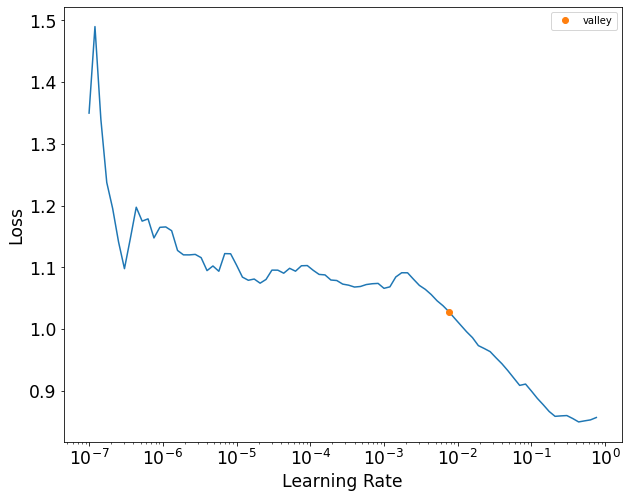

In [74]:
suggested_lr = learn.lr_find()
suggested_lr

### Training

In [75]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,0.999554,0.817122,00:00
1,0.692016,0.399036,00:00
2,0.492404,0.321330,00:00
3,0.391310,0.311825,00:00
4,0.338603,0.302370,00:00
5,0.308028,0.294634,00:00
6,0.289118,0.291346,00:00
7,0.277582,0.286686,00:00
8,0.269348,0.287499,00:00
9,0.264055,0.288058,00:00


In [76]:
# learn.val_preds, learn.val_targets #

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_training


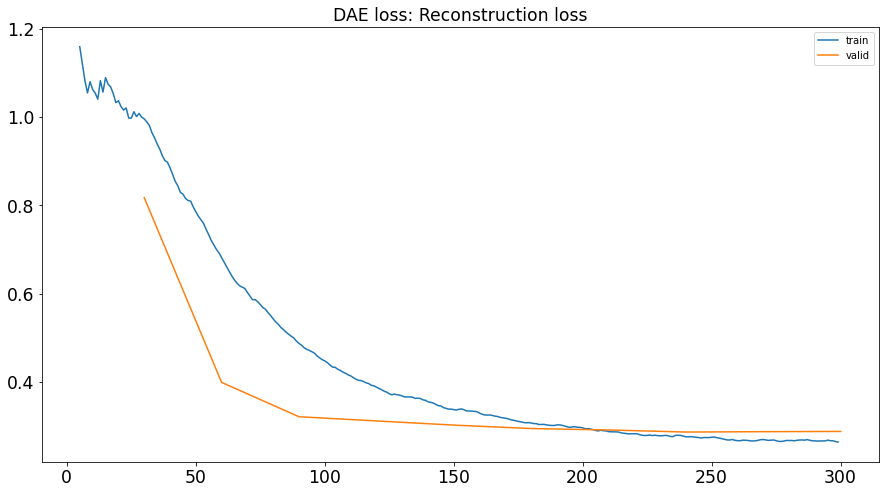

In [77]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('DAE loss: Reconstruction loss')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='dae_training',
                        folder=folder)

In [78]:
# L(zip(learn.recorder.iters, learn.recorder.values))


### Evaluation

In [79]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(4933, 4933)

MSE on transformed data is not too interesting for comparision between models if these use different standardizations

In [80]:
learn.loss_func(pred, target)  # MSE in transformed space not too interesting

TensorBase(0.2884)

In [81]:
# check target is in expected order
Y = dls.valid.targ

npt.assert_almost_equal(
    actual=target.numpy(),
    desired=Y.stack().to_numpy()
)

In [82]:
# import torch
# from fastai.tabular.core import TabularPandas

df_pred['intensity_pred_dae'] = ae.transform_preds(
    pred=pred, index=analysis.df_valid.stack().index, normalizer=tf_norm)
df_pred

intensity  \
Sample ID                            peptide                               
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                29.899   
                                     DSYVGDEAQSK                  32.783   
                                     SLEDQVEMLR                   28.105   
                                     TLGILGLGR                    28.345   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK               29.217   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK             29.613   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK     31.539   
                                     IVSRPEELREDDVGTGAGLLEIK      30.671   
                                     LSVLGAITSVQQR                27.476   
                                     STGEAFVQFASQEIAEK            30.364   

                                                               train_median  \
Sample ID                            peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                   30.250   
                                     DSYVGDEAQSK                     33.542   
                                     SLEDQVEMLR                      28.950   
                                     TLGILGLGR                       28.815   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                  31.081   
...                                                                     ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                29.629   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK        31.468   
                                     IVSRPEELREDDVGTGAGLLEIK         29.922   
                                     LSVLGAITSVQQR                   27.545   
                                     STGEAFVQFASQEIAEK               30.274   

                                                               train_average  \
Sample ID                            peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                    30.245   
                                     DSYVGDEAQSK                      33.310   
                                     SLEDQVEMLR                       28.810   
                                     TLGILGLGR                        28.585   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                   30.827   
...                                                                      ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                 29.761   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK         31.570   
                                     IVSRPEELREDDVGTGAGLLEIK          30.016   
                                     LSVLGAITSVQQR                    27.684   
                                     STGEAFVQFASQEIAEK                30.238   

                                                               replicates  \
Sample ID                            peptide                                
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                 30.008   
                                     DSYVGDEAQSK                   33.189   
                                     SLEDQVEMLR                    28.098   
                                     TLGILGLGR                     28.547   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                30.196   
...                                                                   ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK              29.744   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK      31.623   
                                     IVSRPEELREDDVGTGAGLLEIK       30.115   
                                     LSVLGAITSVQQR                 27.425   
                                     STGEAFVQFASQEIAEK             30.494   

   

### 2D plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [83]:
latent_space = []
for b in dls.valid:
    model_input = b[1]
    latent_space.append(model.encoder(model_input).detach().numpy())

df_dae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_dae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.526,0.257
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.318,0.146
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.744,0.578
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.362,0.302
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.675,0.523


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_date


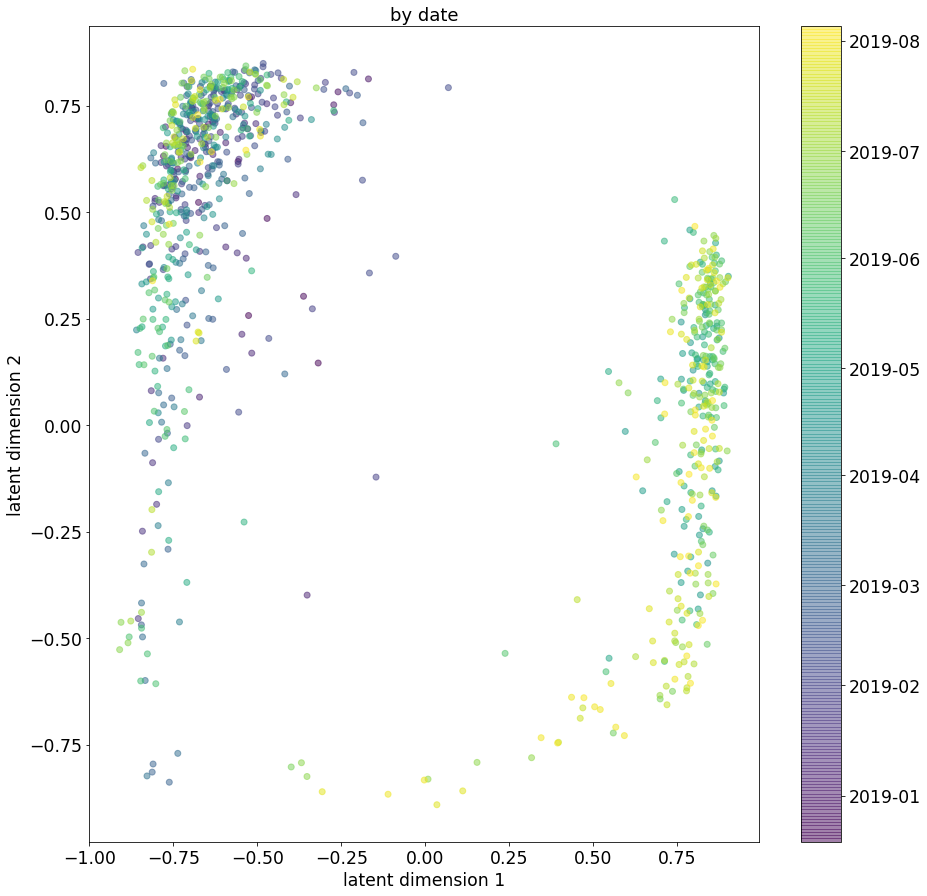

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_dae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_dae_latent.index])
vaep.io_images._savefig(fig, name='dae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_ms_instrument


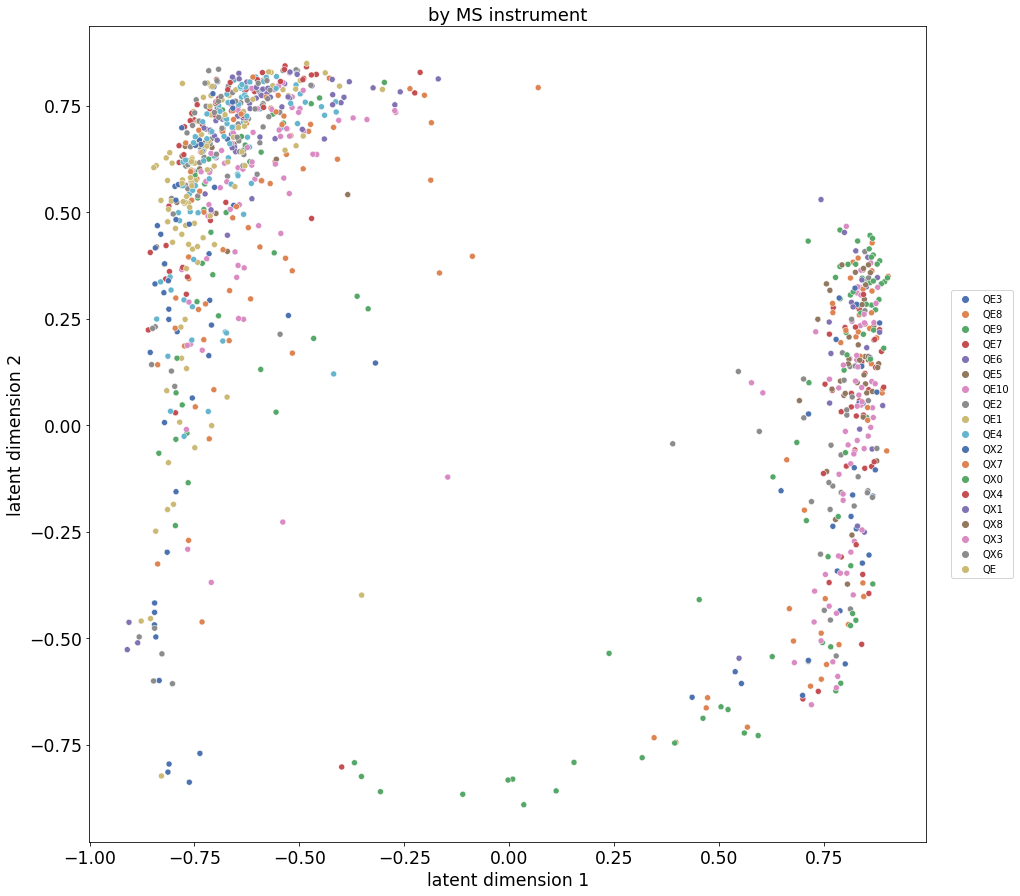

In [85]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_dae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_dae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'dae_latent_by_{meta_col}', folder=folder)

## Variational Autoencoder (VAE)

### Scikit Learn MinMaxScaler

- [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [86]:
from vaep.transform import MinMaxScaler

args_vae = {}
args_vae['SCALER'] = MinMaxScaler
# select initial data: transformed vs not log transformed
scaler = args_vae['SCALER']().fit(analysis.df_train)
scaler.transform(analysis.df_valid.iloc[:5])

peptide,AHSSMVGVNLPQK,ALPFWNEEIVPQIK,AMVSEFLK,AYHEQLSVAEITNACFEPANQMVK,DSYVGDEAQSK,ELAPYDENWFYTR,ELVYPPDYNPEGK,GIHPTIISESFQK,GLVEPVDVVDNADGTQTVNYVPSR,GVNLPGAAVDLPAVSEK,...,TEFLSFMNTELAAFTK,TGTAEMSSILEER,TLGILGLGR,TLHPDLGTDK,VNVPVIGGHAGK,VSFELFADK,VVVAENFDEIVNNENK,YADLTEDQLPSCESLK,YDDMATCMK,YLTVAAVFR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.633,NaN,NaN,NaN,0.738,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.733,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,0.612,NaN,NaN,NaN,NaN,0.466,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,0.393,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.634
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,0.756,NaN,NaN,NaN,0.824,NaN,...,NaN,0.669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DataLoaders

- follow instructions for using plain PyTorch Datasets, see [tutorial](https://docs.fast.ai/tutorial.siamese.html#Preparing-the-data)


In [87]:
assert all(analysis.df_train.columns == analysis.df_valid.columns)
if not all(analysis.df.columns == analysis.df_train.columns):
    print("analysis.df columns are not the same as analysis.df_train")
    # ToDo: DataLoading has to be cleaned up
    # analysis.df = analysis.df_train.fillna(analysis.df_valid)

analysis.df columns are not the same as analysis.df_train


In [88]:
from vaep.io.datasets import PeptideDatasetInMemory

FILL_NA = 0.0

train_ds = PeptideDatasetInMemory(data=scaler.transform(
    analysis.df_train).to_numpy(dtype=None), fill_na=FILL_NA)
valid_ds = PeptideDatasetInMemory(data=scaler.transform(analysis.df_train.fillna(analysis.df_valid)).to_numpy(dtype=None),
                                  mask=analysis.df_valid.notna().to_numpy(), fill_na=FILL_NA)

assert (train_ds.peptides == valid_ds.peptides).all()

In [89]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, n_inp=2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


### Model

In [90]:
from torch.nn import Sigmoid

M = analysis.df_train.shape[-1]
model = ae.VAE(n_features=M, n_neurons=int(
    M/2), last_encoder_activation=None, last_decoder_activation=Sigmoid, dim_latent=latent_dim)

### Learner

In [91]:
learn = Learner(dls=dls,
                model=model,
                loss_func=ae.loss_fct_vae,
                cbs=ae.ModelAdapterVAE())

learn.show_training_loop()
learn.summary()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback

VAE (Input shape: 64 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     64 x 50             
Linear                                    1300       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 4              
Linear                                    104        True      
______________________________________________________________

### Training

SuggestedLRs(valley=0.0020892962347716093)

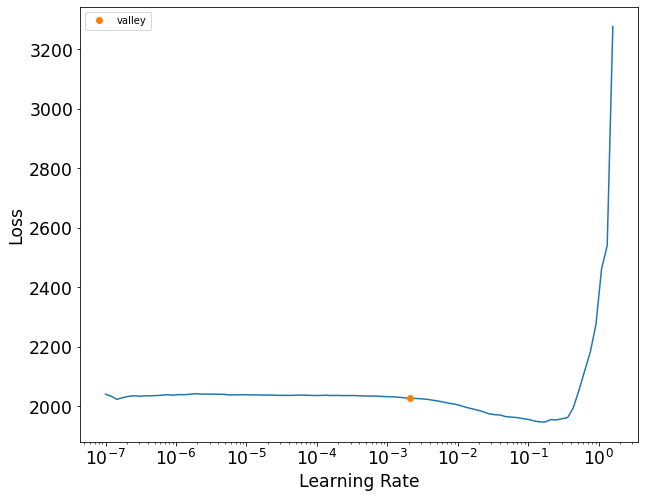

In [92]:
suggested_lr = learn.lr_find()
suggested_lr

In [93]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,2030.367920,221.667953,00:00
1,2000.650146,214.327179,00:00
2,1950.947998,207.411331,00:00
3,1903.320557,203.803909,00:00
4,1865.540894,202.047745,00:00
5,1838.540039,200.467682,00:00
6,1819.487061,197.413116,00:00
7,1805.375244,198.887466,00:00
8,1795.638062,198.276871,00:00
9,1787.440063,198.039719,00:00


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_training


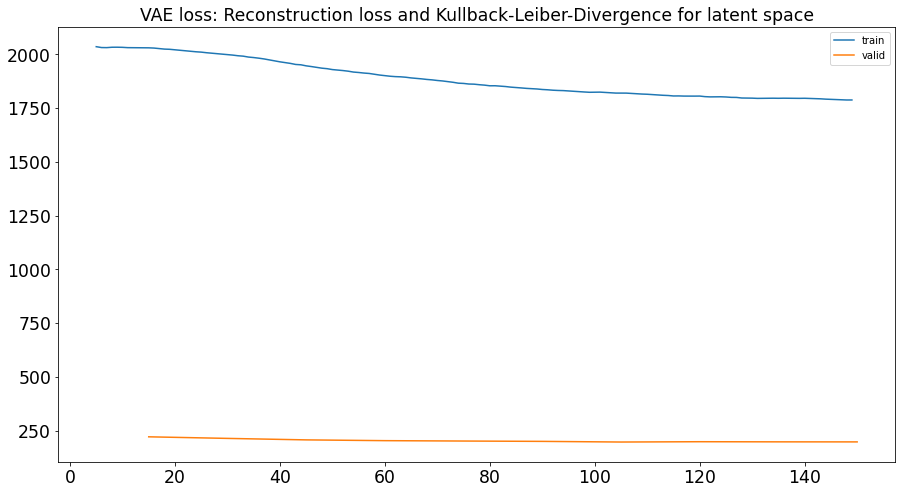

In [94]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('VAE loss: Reconstruction loss and Kullback-Leiber-Divergence for latent space')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='vae_training',
                        folder=folder)

### Evaluation

In [95]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(3, 4933)

In [96]:
len(pred[0])

4933

In [97]:
learn.loss_func(pred, target)

tensor(3108.5349)

In [98]:
_pred = pd.Series(pred[0], index=analysis.df_valid.stack().index).unstack()
_pred = scaler.inverse_transform(_pred).stack()

df_pred['intensity_pred_vae'] = _pred
df_pred

intensity  \
Sample ID                            peptide                               
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                29.899   
                                     DSYVGDEAQSK                  32.783   
                                     SLEDQVEMLR                   28.105   
                                     TLGILGLGR                    28.345   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK               29.217   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK             29.613   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK     31.539   
                                     IVSRPEELREDDVGTGAGLLEIK      30.671   
                                     LSVLGAITSVQQR                27.476   
                                     STGEAFVQFASQEIAEK            30.364   

                                                               train_median  \
Sample ID                            peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                   30.250   
                                     DSYVGDEAQSK                     33.542   
                                     SLEDQVEMLR                      28.950   
                                     TLGILGLGR                       28.815   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                  31.081   
...                                                                     ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                29.629   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK        31.468   
                                     IVSRPEELREDDVGTGAGLLEIK         29.922   
                                     LSVLGAITSVQQR                   27.545   
                                     STGEAFVQFASQEIAEK               30.274   

                                                               train_average  \
Sample ID                            peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                    30.245   
                                     DSYVGDEAQSK                      33.310   
                                     SLEDQVEMLR                       28.810   
                                     TLGILGLGR                        28.585   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                   30.827   
...                                                                      ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK                 29.761   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK         31.570   
                                     IVSRPEELREDDVGTGAGLLEIK          30.016   
                                     LSVLGAITSVQQR                    27.684   
                                     STGEAFVQFASQEIAEK                30.238   

                                                               replicates  \
Sample ID                            peptide                                
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AHSSMVGVNLPQK                 30.008   
                                     DSYVGDEAQSK                   33.189   
                                     SLEDQVEMLR                    28.098   
                                     TLGILGLGR                     28.547   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ALPFWNEEIVPQIK                30.196   
...                                                                   ...   
20190805_QE1_nLC2_AB_MNT_HELA_03     VVVAENFDEIVNNENK              29.744   
20190805_QE1_nLC2_AB_MNT_HELA_04     AYHEQLSVAEITNACFEPANQMVK      31.623   
                                     IVSRPEELREDDVGTGAGLLEIK       30.115   
                                     LSVLGAITSVQQR                 27.425   
                                     STGEAFVQFASQEIAEK             30.494   

   

### Add plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [99]:
latent_space = []
for b in dls.valid:
    model_input = b[0]
    b_mu, b_std = model.get_mu_and_logvar(model_input, detach=True)
    latent_space.append(b_mu)


df_vae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_vae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.117,-0.239
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.150,-0.235
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.042,-0.039
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.034,-0.083
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.045,-0.163


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_date


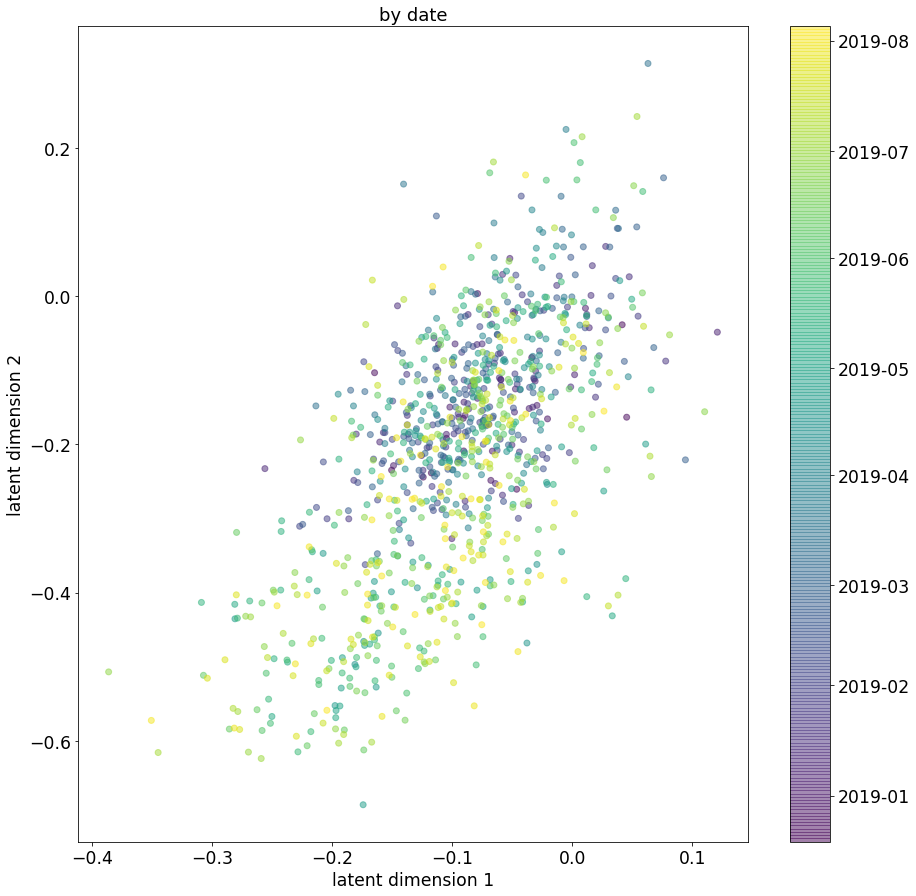

In [100]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_vae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_vae_latent.index])
vaep.io_images._savefig(fig, name='vae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_ms_instrument


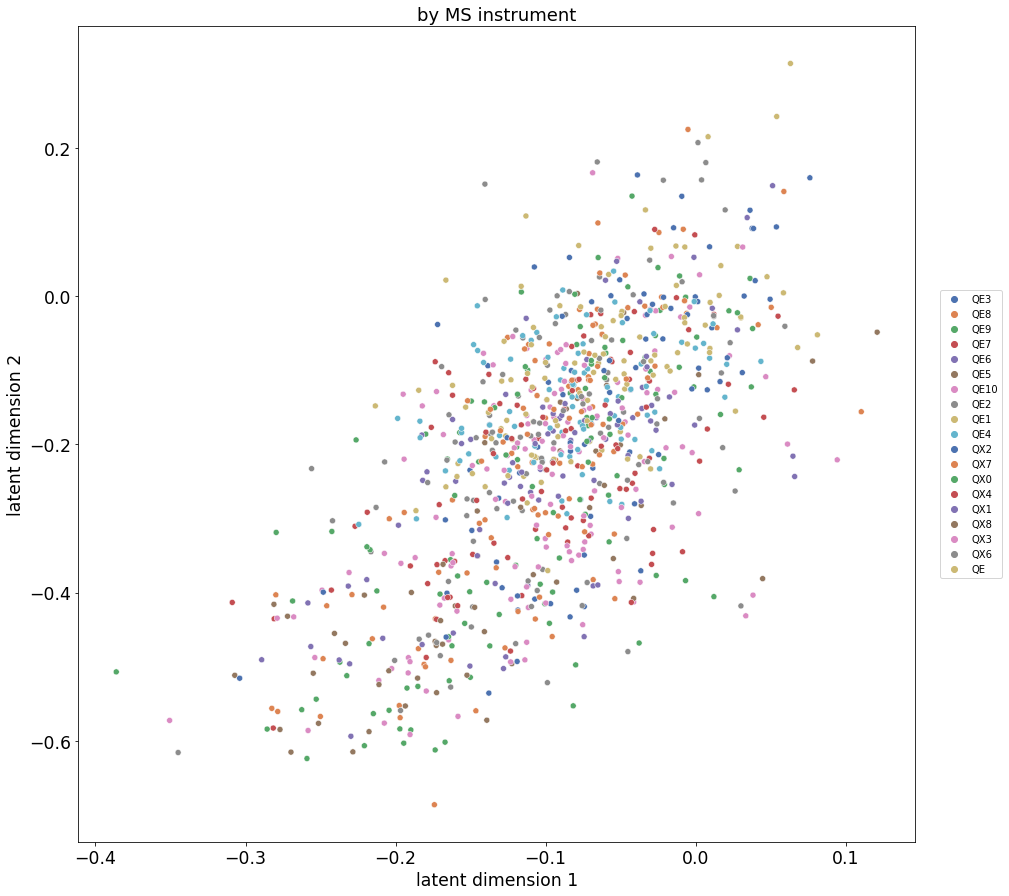

In [101]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_vae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_vae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'vae_latent_by_{meta_col}', folder=folder)

## Compare the 3 models

- replicates: replace NAs with neighbouring ("close") values
- train average, median: Replace NA with average or median from training data

In [102]:
import sklearn.metrics as sklm
pred_columns = df_pred.columns[1:]
scoring = [('MSE', sklm.mean_squared_error),
           ('MAE', sklm.mean_absolute_error)]

y_true = df_pred['intensity']

metrics = {}
for col in pred_columns:
    _y_pred = df_pred[col].dropna()
    if len(df_pred[col]) > len(_y_pred):
        logger.info(
            f"Drop indices for {col}: {[(idx[0], idx[1]) for idx in df_pred[col].index.difference(_y_pred.index)]}")

    metrics[col] = dict(
        [(k, f(y_true=y_true.loc[_y_pred.index], y_pred=_y_pred))
         for k, f in scoring]
    )

metrics = pd.DataFrame(metrics)
metrics.to_csv(folder / f'exp_02_metrics.csv',
               float_format='{:.3f}'.format)
metrics.sort_values(by=[k for k, f in scoring], axis=1)

vaep - INFO     Drop indices for replicates: [('20181230_QE6_nLC6_CSC_QC_HeLa_03', 'KHPDASVNFSEFSK'), ('20190107_QE10_nLC0_KS_QC_MNT_HeLa_01', 'GVNLPGAAVDLPAVSEK'), ('20190110_QE8_nLC14_JM_QC_MNT_HeLa_02', 'STGEAFVQFASQEIAEK'), ('20190114_QE4_LC6_IAH_QC_MNT_HeLa_250ng_01', 'LVNHFVEEFK'), ('20190121_QE5_nLC5_AH_QC_MNT_HeLa_250ng_01', 'SLEDQVEMLR'), ('20190121_QE5_nLC5_AH_QC_MNT_HeLa_250ng_02', 'SLEDQVEMLR'), ('20190204_QE6_nLC6_MPL_QC_MNT_HeLa_01', 'GVNLPGAAVDLPAVSEK'), ('20190205_QE7_nLC7_MEM_QC_MNT_HeLa_03', 'HQPTAIIAK'), ('20190205_QE7_nLC7_MEM_QC_MNT_HeLa_04', 'HQPTAIIAK'), ('20190218_QE6_LC6_SCL_MVM_QC_MNT_Hela_03', 'HQPTAIIAK'), ('20190219_QE2_NLC1_GP_QC_MNT_HELA_01', 'VSFELFADK'), ('20190225_QE10_PhGe_Evosep_88min_HeLa_1_20190225173940', 'LVNHFVEEFK'), ('20190225_QE10_PhGe_Evosep_88min_HeLa_2', 'LVNHFVEEFK'), ('20190225_QE9_nLC0_RS_MNT_Hela_02', 'VSFELFADK'), ('20190228_QE4_LC12_JE_QC_MNT_HeLa_01', 'VNVPVIGGHAGK'), ('20190301_QE1_nLC2_ANHO_QC_MNT_HELA_01_20190303025443', 'IIQLLDD

,intensity_pred_collab,intensity_pred_dae,replicates,intensity_pred_vae,train_average,train_median
MSE,0.502,0.542,1.505,1.980,2.023,2.099
MAE,0.434,0.463,0.854,1.065,1.067,1.052


Save final prediction values of validation data for later comparison.

In [103]:
df_pred.to_csv(folder /
               f"{config.FOLDER_DATA}_valid_pred.csv")

## PCA plot for imputed and denoised data

two setups:
 - impute missing values
 - additinally change observed values